In [1]:
import os
import re
import heapq
import numpy as np
import cv2
import vtk
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from PIL import Image, ImageDraw
from vtk.util.numpy_support import vtk_to_numpy


## Read data

In [2]:
def numerical_sort(value):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', value)]


def get_img_list(root):
    img_list = []
    
    for img in sorted(os.listdir(root), key=numerical_sort):
        img_list.append(root+'\\'+img)
    return img_list


In [3]:
img_list7_orig = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_7\Orig")
img_list8_orig = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_8\Orig")

img_list0_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_0\Segmented2\RegUnSharpenedB")
img_list1_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_1\Segmented2\RegUnSharpenedB")
img_list3_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_3\Segmented2\RegUnSharpenedB")
img_list4_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_4\Segmented2\RegUnSharpenedB")
img_list6_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_6\Segmented2\RegUnSharpenedB")
img_list7_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_7\Segmented\Corrected")
img_list8_seg = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_8\Segmented\Corrected")

img_list7_sift = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_7\RegisteredSIFT")
img_list8_sift = get_img_list(".\AngioData\AngioData\ImsegmentedPt_02 V_8\RegisteredSIFT")

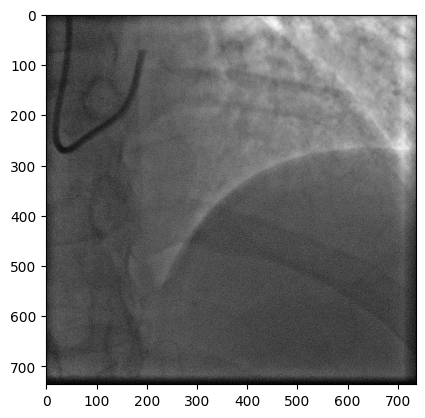

In [4]:
sample_img = Image.open(img_list7_orig[0])
plt.imshow(sample_img,cmap='gray')  # 736*736

## 2D Astar velocity prediction 

In [5]:
image1 = Image.open(img_list7_sift[2])
image2 = Image.open(img_list7_sift[3])

In [5]:
def nearest_point(arr):
    max_distance = len(arr)+len(arr[0]) 
    for distance in range(1, max_distance + 1):
        for i in range(distance):
            if arr[i][distance-i] == 1:
                return (i, distance-i)
    return None

def heuristic(point, goal):
    return abs(point[0] - goal[0]) + abs(point[1] - goal[1])

def a_star(map_array, start_point):
    rows, cols = len(map_array), len(map_array[0])
    distances = [[float('inf')] * cols for _ in range(rows)]
    
    min_heap = [(0, start_point)]
    distances[start_point[0]][start_point[1]] = 0
    
    while min_heap:
        distance, (row, col) = heapq.heappop(min_heap)
        
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols and map_array[new_row][new_col] == 1:
                new_distance = distances[row][col] + 1
                if new_distance < distances[new_row][new_col]:
                    distances[new_row][new_col] = new_distance
                    priority = new_distance + heuristic((new_row, new_col), start_point)
                    heapq.heappush(min_heap, (priority, (new_row, new_col)))
    
    distances = np.array(distances)
    distances[distances == float('inf')] = -1
 
    return distances

In [6]:
def predict_velocity(img1, img2):

    image_array1 = np.array(img1)
    image_array2 = np.array(img2)
    image_array1 = image_array1 > 0
    image_array2 = image_array2 > 0

    start_point1 = nearest_point(image_array1)
    distances1 = a_star(image_array1, start_point1)

    start_point2 = nearest_point(image_array2)
    distances2 = a_star(image_array2, start_point2)

    max_distance1 = np.max(distances1)
    max_distance2 = np.max(distances2)

    velocity = abs(max_distance1-max_distance2)
    print("The predicted blood flow velocity is", velocity, 'pixels/frame')

    return velocity

In [8]:
image1 = Image.open(img_list7_sift[2])
image2 = Image.open(img_list7_sift[3])
velocity = predict_velocity(image1,image2)

The predicted blood flow velocity is 202.0 pixels/frame


In [9]:
image3 = Image.open(img_list7_sift[4])
velocity = predict_velocity(image3,image2)

The predicted blood flow velocity is 142.0 pixels/frame


In [7]:
def draw_end_point(image):
    image_array = np.array(image)
    image_array = image_array > 0
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)
    start_point = nearest_point(image_array)

    distances = a_star(image_array, start_point)
    max_distance = np.max(distances)
    print("Max D:", max_distance)

    max_index = np.argmax(distances)
    max_coord = np.unravel_index(max_index, distances.shape)
    point = (max_coord[1], max_coord[0])

    color = 255 
    point_size = 20

    draw.rectangle([point[0] - point_size // 2, point[1] - point_size // 2, point[0] + point_size // 2, point[1] + point_size // 2], fill=color)

    plt.imshow(image_copy, cmap='gray')
    plt.show()

Max D: 1082.0


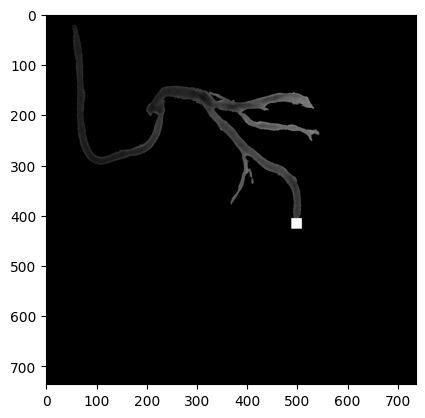

In [11]:
draw_end_point(image1)

Max D: 1284.0


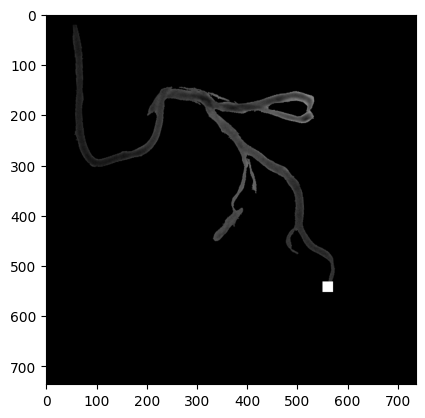

In [12]:
draw_end_point(image2)

Max D: 1426.0


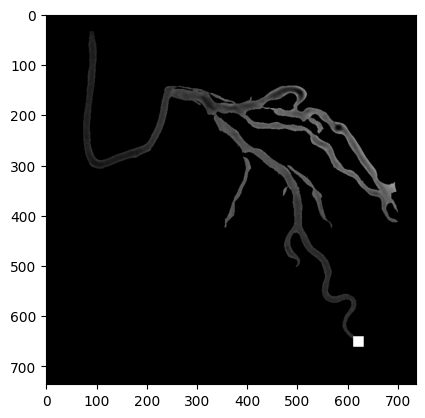

In [13]:
draw_end_point(image3)

## 2D distance visualization

In [8]:
def distance_normalization(distances):
    max_val = np.max(distances[distances > 0])
    distances = np.where(distances > 0, distances/max_val, distances)
    return distances


def map_value_to_color(value):
    if value == -1:
        return (0, 0, 0)  # black
    else:
        # 0-100 to blue-red
        return (int(255*value), 0, int(255*(1-value))) 


def distance_visualiztion(image):
    image_array = np.array(image)
    image_array = image_array > 0
    start_point = nearest_point(image_array)
    distances = a_star(image_array, start_point)
    distances = distance_normalization(distances)

    width, height = len(distances[0]), len(distances)
    img = Image.new('RGB', (width, height))

    pixels = img.load()
    for y in range(height):
        for x in range(width):
            pixels[x, y] = map_value_to_color(distances[y][x])

    img.show()
    img.save('visualization.png')

In [15]:
distance_visualiztion(image3)

## Branch velocity estimation

In [9]:
def find_branch_endpoints(image, n):
    image_array = np.array(image)
    image_array = image_array > 0
    start_point = nearest_point(image_array)
    distances = a_star(image_array, start_point)

    endpoints = {}
    rows, cols = len(distances), len(distances[0])

    for i in range(rows):
        for j in range(cols):
            if distances[i][j] >= 0:
                surrounding = np.copy(distances[max(0, i - n // 2):min(rows, i + n // 2 + 1),max(0, j - n // 2):min(cols, j + n // 2 + 1)])
                if np.max(surrounding) == distances[i][j]:
                    endpoints[(i, j)] = distances[i][j]
    return endpoints

def branch_visualization(image,endpoints):
    color = 255 
    point_size = 10
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)

    for point in endpoints:
        draw.rectangle([point[1] - point_size // 2, point[0] - point_size // 2, point[1] + point_size // 2, point[0] + point_size // 2],fill=color)

    plt.imshow(image_copy, cmap='gray')
    plt.show()

In [10]:
def test_endpoints(img1, img2, n):
    endpoints1 = find_branch_endpoints(img1,n)
    endpoints2 = find_branch_endpoints(img2,n)
    print(endpoints1)
    print(endpoints2)

    branch_visualization(img1,endpoints1)
    branch_visualization(img2,endpoints2)



{(188, 533): 895.0, (239, 543): 950.0, (240, 542): 950.0, (378, 367): 967.0, (379, 368): 967.0, (416, 498): 1082.0}
{(197, 530): 907.0, (207, 532): 907.0, (447, 331): 1072.0, (448, 332): 1072.0, (449, 333): 1072.0, (450, 334): 1072.0, (451, 335): 1072.0, (542, 560): 1284.0, (543, 561): 1284.0, (545, 563): 1284.0}


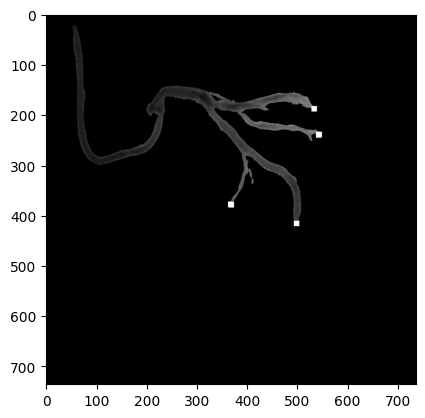

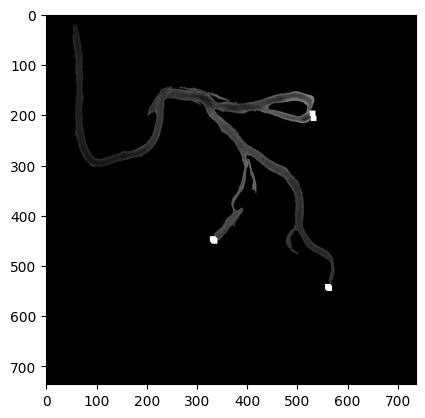

In [16]:
test_endpoints(Image.open(img_list7_sift[2]),Image.open(img_list7_sift[3]),70)

In [29]:
endpoints = find_branch_endpoints(image3,70)

In [30]:
endpoints

[(413, 700), (503, 496), (651, 621)]

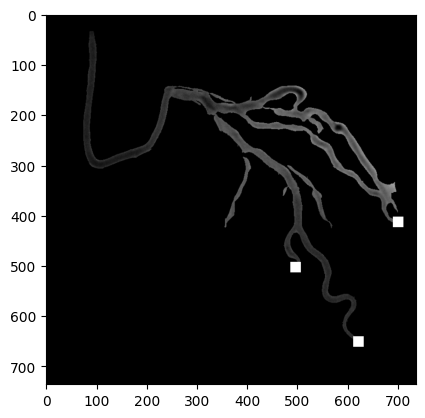

In [31]:
branch_visualization(image3,endpoints)

In [33]:
endpoints = find_branch_endpoints(image2,70)


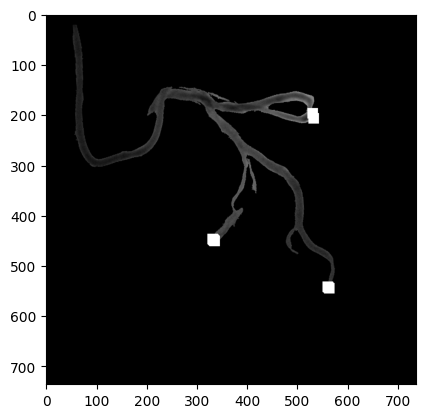

In [34]:
branch_visualization(image2,endpoints)

## SIFT Registration

In [14]:
reg_img1 = np.array(Image.open(img_list7_seg[17]))#[0:400]
reg_img2 = np.array(Image.open(img_list7_seg[18]))#[0:400]

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(reg_img1, None)
print(len(keypoints1))
keypoints2, descriptors2 = sift.detectAndCompute(reg_img2, None)
print(len(keypoints2))

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors1, descriptors2, k=2)
# matcher = cv2.FlannBasedMatcher()
# matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.96 * n.distance:
        good_matches.append(m)

print(len(good_matches))

points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

transformation_matrix, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

registered_img1 = cv2.warpPerspective(reg_img1, transformation_matrix, (736, 736))



108
149
82


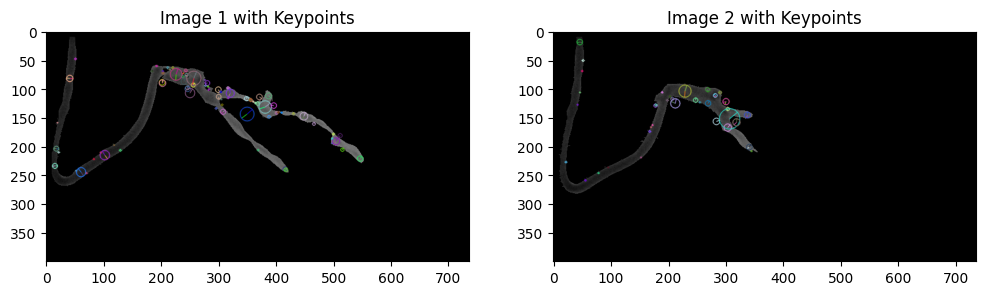

In [56]:
img1_with_keypoints = cv2.drawKeypoints(reg_img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_with_keypoints = cv2.drawKeypoints(reg_img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img1_with_keypoints, cmap='gray'), plt.title('Image 1 with Keypoints')
plt.subplot(122), plt.imshow(img2_with_keypoints, cmap='gray'), plt.title('Image 2 with Keypoints')
plt.show()

## Intensity of distribution

In [10]:


def get_intensity(img_paths):
    ves = []
    for img_path in img_paths:
        img = Image.open(img_path)
        img = np.array(img)
        count = np.count_nonzero(img)
        ves.append(count/img.size)

    return ves

In [11]:
first_img_list = [img_list0_seg[0],img_list1_seg[0],img_list3_seg[0],img_list4_seg[0],img_list6_seg[0],img_list7_seg[0],img_list8_seg[0]]
last_img_list = [img_list0_seg[-1],img_list1_seg[-1],img_list3_seg[-1],img_list4_seg[-1],img_list6_seg[-1],img_list7_seg[-1],img_list8_seg[-2]]
ax_label = ['set00','set01','set03','set04','set06','set07','set08']


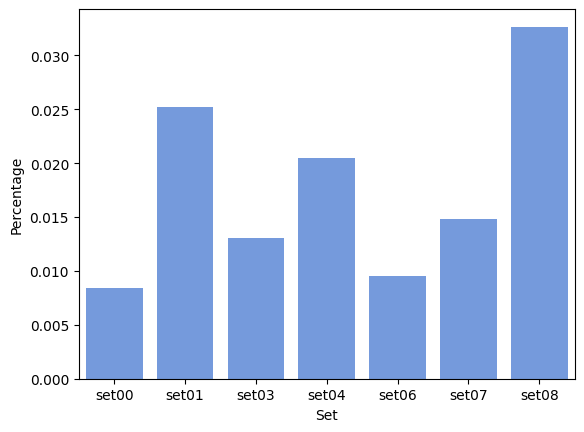

In [12]:
#The percentage of pixels segmented as vessels in the image
distribution_first = get_intensity(first_img_list)
sns.barplot(x=ax_label, y=distribution_first, color="#6495ED")
plt.xlabel('Set')
plt.ylabel('Percentage')
plt.show()

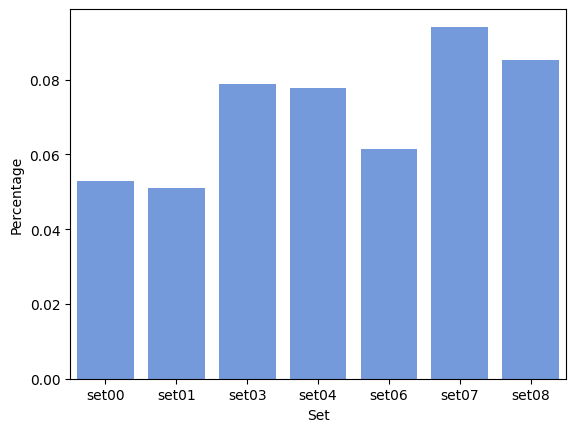

In [13]:
distribution_last = get_intensity(last_img_list)
sns.barplot(x=ax_label, y=distribution_last, color="#6495ED")
plt.xlabel('Set')
plt.ylabel('Percentage')
plt.show()

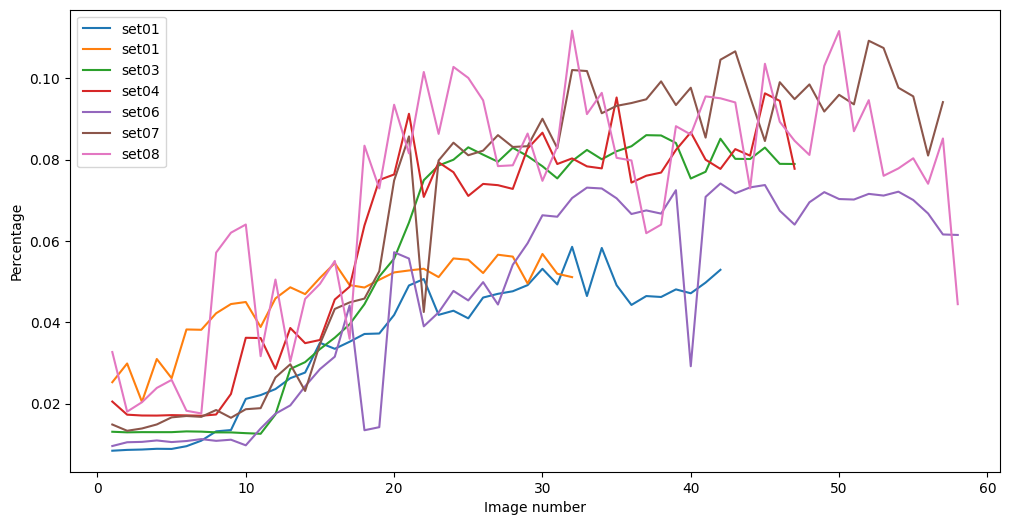

In [14]:
distribution0 = get_intensity(img_list0_seg)
distribution1 = get_intensity(img_list1_seg)
distribution3 = get_intensity(img_list3_seg)
distribution4 = get_intensity(img_list4_seg)
distribution6 = get_intensity(img_list6_seg)
distribution7 = get_intensity(img_list7_seg)
distribution8 = get_intensity(img_list8_seg)


plt.figure(figsize=(12, 6))
sns.lineplot(x=np.array(range(1,len(distribution0)+1)), y=distribution0, label='set01')
sns.lineplot(x=np.array(range(1,len(distribution1)+1)), y=distribution1, label='set01')
sns.lineplot(x=np.array(range(1,len(distribution3)+1)), y=distribution3, label='set03')
sns.lineplot(x=np.array(range(1,len(distribution4)+1)), y=distribution4, label='set04')
sns.lineplot(x=np.array(range(1,len(distribution6)+1)), y=distribution6, label='set06')
sns.lineplot(x=np.array(range(1,len(distribution7)+1)), y=distribution7, label='set07')
sns.lineplot(x=np.array(range(1,len(distribution8)+1)), y=distribution8, label='set08')
plt.xlabel('Image number')
plt.ylabel('Percentage')

plt.show()


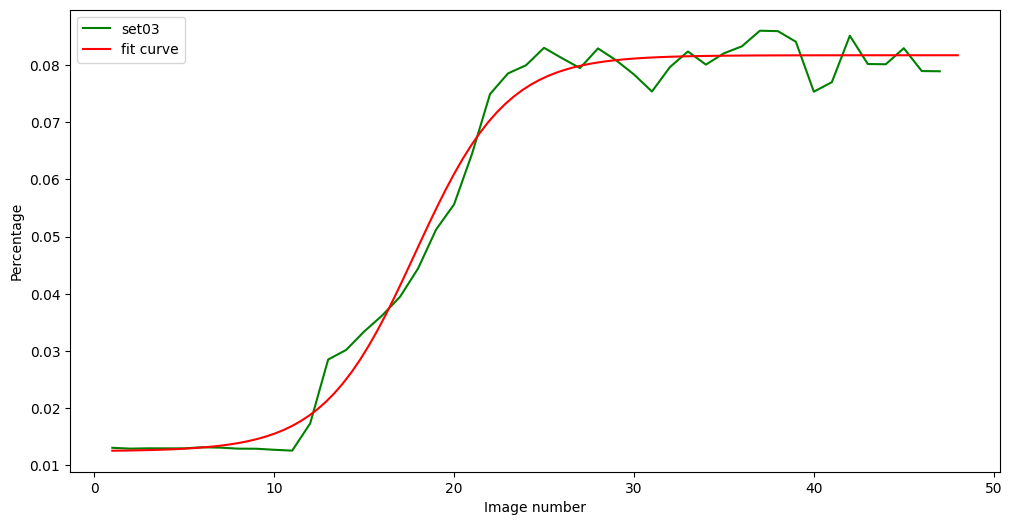

In [15]:
def sigmoid(x, a, b, c, d):
    return d / (1 + np.exp(-(a*x+b))) + c

x_data = np.array(range(1,len(distribution3)+1))
y_data = [i for i in distribution3]

params, covariance = curve_fit(sigmoid, x_data, y_data)

a, b, c, d = params

x_fit = np.linspace(1, 48, 100)
y_fit = sigmoid(x_fit, a, b, c, d)


plt.figure(figsize=(12, 6))
sns.lineplot(x=np.array(range(1,len(distribution3)+1)), y=distribution3, label='set03', color='green')
sns.lineplot(x=x_fit, y=y_fit, label='fit curve',color='red')
plt.legend()
plt.xlabel('Image number')
plt.ylabel('Percentage')
plt.show()

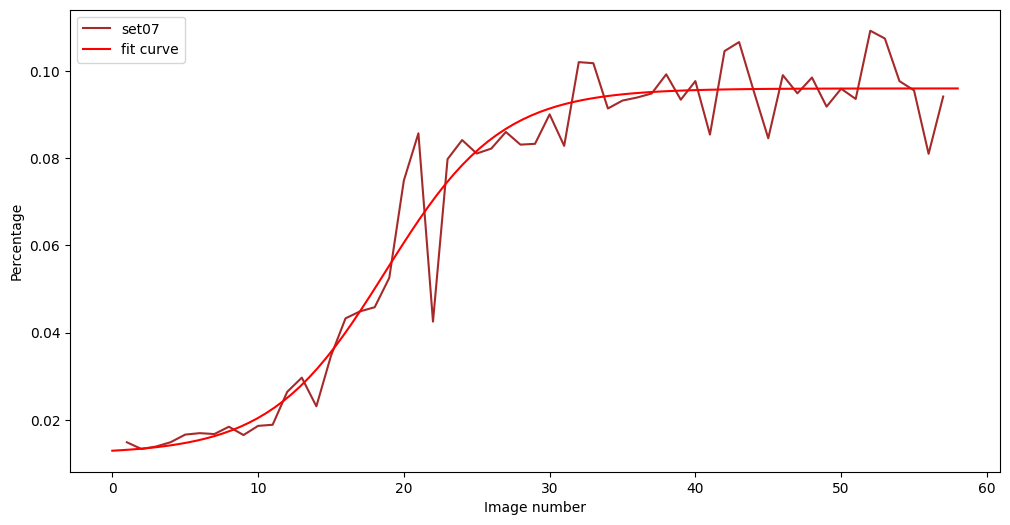

In [16]:
def sigmoid(x, a, b, c, d):
    return d / (1 + np.exp(-(a*x+b))) + c

x_data = np.array(range(1,len(distribution7)+1))
y_data = [i for i in distribution7]


initial_guess = [a, b, c, d]
params, covariance = curve_fit(sigmoid, x_data, y_data, p0=initial_guess)

a, b, c, d = params

x_fit = np.linspace(0, 58, 100)
y_fit = sigmoid(x_fit, a, b, c, d)


plt.figure(figsize=(12, 6))
sns.lineplot(x=np.array(range(1,len(distribution7)+1)), y=distribution7, label='set07', color='brown')
sns.lineplot(x=x_fit, y=y_fit, label='fit curve',color='red')
plt.legend()
plt.xlabel('Image number')
plt.ylabel('Percentage')
plt.show()

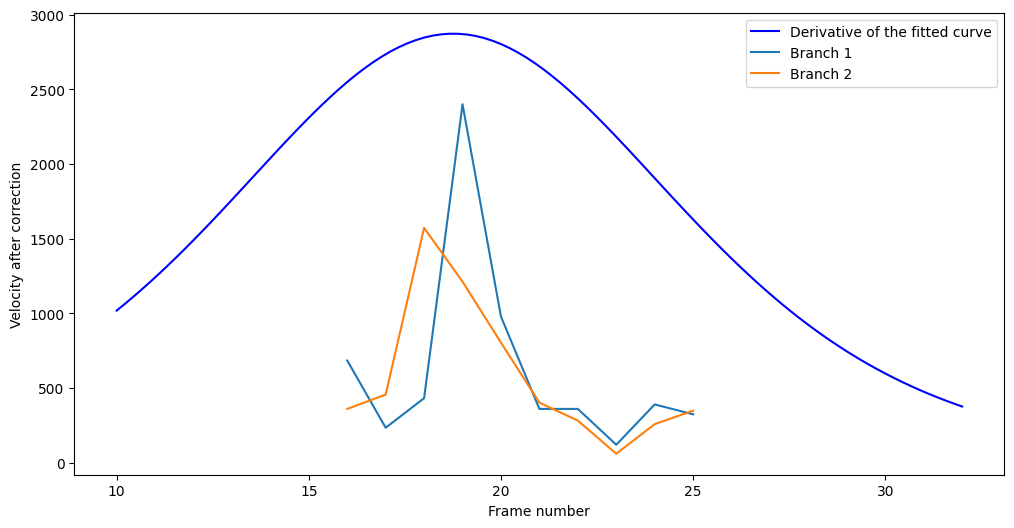

In [28]:
def sigmoid_derivative(x, a, b, c, d):
    exp_term = np.exp(-a * x - b)
    return a * d * exp_term / (1 + exp_term) ** 2

x_data = np.array(range(1, len(distribution7) + 1))
y_data = np.array(distribution7) 
x_fit = np.linspace(10, 32, 100)
y_fit = sigmoid(x_fit, a, b, c, d)
y_fit_derivative = sigmoid_derivative(x_fit, a, b, c, d)


x_values = list(range(16, 15 + 11))
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_fit, y=y_fit_derivative*736*736, label='Derivative of the fitted curve', color='blue')
sns.lineplot(x=x_values,y=(pd.read_excel('test.xlsx', usecols=[1]).head(10).values.flatten()+60)*6,label='Branch 1')
sns.lineplot(x=x_values,y=(pd.read_excel('test.xlsx', usecols=[5]).head(10).values.flatten()+60)*6,label='Branch 2')
plt.legend()
plt.xlabel('Frame number')
plt.ylabel('Velocity after correction')
plt.show()

In [59]:
y_fit_derivative

array([1.80983556e-04, 2.09326219e-04, 2.42002281e-04, 2.79638624e-04,
       3.22940715e-04, 3.72698267e-04, 4.29789726e-04, 4.95184823e-04,
       5.69944199e-04, 6.55214816e-04, 7.52219556e-04, 8.62239044e-04,
       9.86583409e-04, 1.12655137e-03, 1.28337397e-03, 1.45814021e-03,
       1.65170263e-03, 1.86456159e-03, 2.09672932e-03, 2.34757729e-03,
       2.61567459e-03, 2.89862978e-03, 3.19295395e-03, 3.49396813e-03,
       3.79578132e-03, 4.09136603e-03, 4.37275371e-03, 4.63136140e-03,
       4.85844462e-03, 5.04564932e-03, 5.18561408e-03, 5.27255523e-03,
       5.30275967e-03, 5.27491582e-03, 5.19023316e-03, 5.05233194e-03,
       4.86692008e-03, 4.64130568e-03, 4.38381419e-03, 4.10318551e-03,
       3.80801882e-03, 3.50631508e-03, 3.20514485e-03, 2.91044776e-03,
       2.62695241e-03, 2.35819483e-03, 2.10660881e-03, 1.87366144e-03,
       1.66001081e-03, 1.46566777e-03, 1.29014907e-03, 1.13261416e-03,
       9.91981682e-04, 8.67024815e-04, 7.56446382e-04, 6.58935825e-04,
      

In [ ]:
def sigmoid_derivative(x, a, b, c, d):
    exp_term = np.exp(-a * x - b)
    return a * d * exp_term / (1 + exp_term) ** 2

x_data = np.array(range(1, len(distribution7) + 1))
y_data = np.array(distribution7) 
x_fit = np.linspace(0, 58, 100)
y_fit = sigmoid(x_fit, a, b, c, d)
y_fit_derivative = sigmoid_derivative(x_fit, a, b, c, d)

plt.figure(figsize=(12, 6))
sns.lineplot(x=x_fit, y=y_fit_derivative*736*736, label='Derivative of the fitted curve', color='blue')
sns.lineplot(x=[18,19,20,21],y=[16/736,202/736,142/736,24/736],label='branch 1')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Surface model

In [36]:
reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName("solid_400005.vtp")

reader.Update()

polydata = reader.GetOutput()

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(polydata)

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0, 0, 0)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

interactor.Initialize()
render_window.Render()
interactor.Start()

In [3]:
reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName("solid_400005.vtp")
reader.Update()

poly_data = reader.GetOutput()

bounds = poly_data.GetBounds()
center = [(bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2]

renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

camera = renderer.GetActiveCamera()
camera.SetFocalPoint(center[0], center[1], center[2])
camera.SetPosition(center[0], center[1], center[2] + 2 * max(bounds))

plane = vtk.vtkPlane()
plane.SetOrigin(center[0], center[1], center[2])
plane.SetNormal(0, 0, 1)

cutter = vtk.vtkCutter()
cutter.SetCutFunction(plane)
cutter.SetInputData(poly_data)
cutter.Update()

projection_images = []

for i in range(4):
    angle = math.radians(i * 90)
    camera.SetPosition(center[0] + 2 * max(bounds) * math.cos(angle), center[1] + 2 * max(bounds) * math.sin(angle), center[2])
    camera.SetViewUp(0, 1, 0)
    renderer.ResetCameraClippingRange()
    render_window.Render()

    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)
    render_window_interactor.Render()

    window_to_image_filter = vtk.vtkWindowToImageFilter()
    window_to_image_filter.SetInput(render_window)
    window_to_image_filter.Update()

    projection_images.append(window_to_image_filter.GetOutput())

render_window.Finalize()
render_window_interactor.TerminateApp()



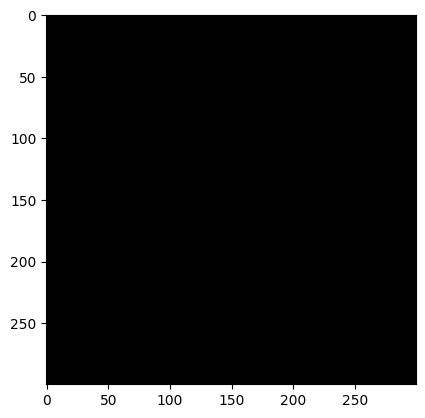

In [4]:
image_data = projection_images[0]
height, width, _ = image_data.GetDimensions()
vtk_image = image_data.GetPointData().GetScalars()
array = vtk_to_numpy(vtk_image).reshape(height, width,3)

plt.imshow(array)
plt.show()